<a href="https://colab.research.google.com/github/hjn14133/Machine-Learning/blob/main/XGB_Regression_Yield.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn

from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import RFE
from math import log
import matplotlib
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv("FT_join_JH_cleaned.csv")


In [6]:
X = df[['DISTANCE', 'Heading','Elevation', 'AppliedRat']]
y = df['VRYIELDBAL']

# y = df['Loan_Rat']

In [8]:
# Perform data splitting using 80/20 ratio
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

In [29]:
xgb = XGBRegressor(random_state=1)
xgb.fit(X_train, Y_train)
Y_preds = xgb.predict(X_test)

print('Training Coefficient of R^2 : %.3f'%xgb.score(X_train, Y_train))
print('Test Coefficient of R^2 : %.3f'%xgb.score(X_test, Y_test))

xgb.get_params()

[20:13:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training Coefficient of R^2 : 0.623
Test Coefficient of R^2 : 0.587


{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'importance_type': 'gain',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'reg:linear',
 'random_state': 1,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

In [33]:
# Calculate the absolute errors
errors = abs(Y_preds - Y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), '.')


# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / Y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 0.42 .
Accuracy: 70.89 %.


In [30]:
# Get numerical feature importances
importances = list(xgb.feature_importances_)
feature_list = list(X.columns)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: DISTANCE             Importance: 0.550000011920929
Variable: Elevation            Importance: 0.25999999046325684
Variable: AppliedRat           Importance: 0.12999999523162842
Variable: Heading              Importance: 0.05999999865889549


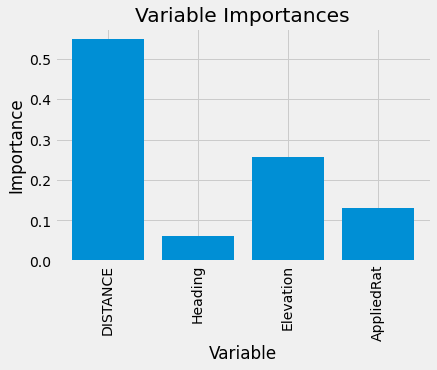

In [31]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [28]:
# Various hyper-parameters to tune
xgb1 = XGBRegressor()
parameters = {'nthread':[1], #when use hyperthread, xgboost may become slower
              'booster':['gbtree'],
              'objective':['reg:linear'],
              'learning_rate': [0.05, 0.1,0.2, 0.3], #so called `eta` value [0.01-0.2]
              'max_depth': [3, 4, 5, 6], #6, [3, 10]
              #'min_child_weight': [1, 2, 3], #1, too high-under-fitting
              #'silent': [0, 1],
              #'subsample': [0.5, 0.75, 1],
              #'colsample_bytree': [0.5, 0.7, 1],
              'n_estimators': [300, 500, 1000]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train, Y_train)

print('Train R^2 Score : %.3f'%xgb_grid.best_estimator_.score(X_train, Y_train))
print('Test R^2 Score : %.3f'%xgb_grid.best_estimator_.score(X_test, Y_test))
print('Best R^2 Score Through Grid Search : %.3f'%xgb_grid.best_score_)
print('Best Parameters : ',xgb_grid.best_params_)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.0min
[Parallel(n_jobs=5)]: Done  96 out of  96 | elapsed:  2.6min finished


[20:08:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train R^2 Score : 0.852
Test R^2 Score : 0.698
Best R^2 Score Through Grid Search : 0.672
Best Parameters :  {'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 500, 'nthread': 1, 'objective': 'reg:linear'}
0.6720831736515014
{'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 500, 'nthread': 1, 'objective': 'reg:linear'}


In [36]:
Y_preds_grid = xgb_grid.predict(X_test)
# Calculate the absolute errors
error_grid = abs(Y_preds_grid - Y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(error_grid), 2), '.')


# Calculate mean absolute percentage error (MAPE)
mape_grid = 100 * (error_grid / Y_test)
# Calculate and display accuracy
accuracy_grid = 100 - np.mean(mape_grid)
print('Accuracy:', round(accuracy_grid, 2), '%.')

Mean Absolute Error: 0.36 .
Accuracy: 74.75 %.


In [38]:

print('Improvement of {:0.2f}%.'.format( 100 * (accuracy_grid - accuracy) / accuracy))

Improvement of 5.45%.
